In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
import sys
sys.path.append('../core')
%matplotlib inline

In [2]:
import torch
torch.manual_seed(0)
import torch.optim as optim

In [3]:
import dojo
from display import*
from FFA import FFA

In [4]:
#2-layer 784-800-10
class DNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.s = 28**2
        self.p = 800
        self.nl = 10
        
        self.activation = torch.nn.functional.relu
        self.prob = torch.nn.functional.softmax
        
        self.pre = lambda x : x.reshape((x.shape[0], np.prod(x.shape[1:]))).to(torch.float32)
        self.layers = torch.nn.ModuleList([torch.nn.Linear(self.s, self.p, bias=False), torch.nn.Linear(self.p, self.nl, bias=False)])
        self.post = [self.activation,self.prob]

        self.criterion = torch.nn.MSELoss()     
        
    ###############    
    def train(self, x, y, optimizer, return_outputs):
        outputs = self.forward(x)
        loss = self.criterion(outputs, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    ###############   
    
    def forward(self, x):
        x = self.pre(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.post[i](x)
        return x

    def predict(self,x):
        x = self.forward(x)
        return torch.argmax(x,axis=-1)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # as other apps are currently using gpu
print(device)

from keras.datasets import mnist

(train_X, train_y_idx), (test_X, test_y_idx) = mnist.load_data()
n = train_X.shape[0]
nt = test_X.shape[0]
train_X = torch.from_numpy(train_X).to(torch.float32).to(device)
test_X = torch.from_numpy(test_X).to(torch.float32).to(device)

train_y = np.zeros((n,10))
for i in range(train_y.shape[0]):
    train_y[i,train_y_idx[i]] = 1.0
train_y = torch.from_numpy(train_y).to(torch.float32).to(device)

test_y = np.zeros((nt,10))
for i in range(test_y.shape[0]):
    test_y[i,test_y_idx[i]] = 1.0
test_y = torch.from_numpy(test_y).to(torch.float32).to(device)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

cuda:0


2023-02-25 02:34:10.607191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 02:34:11.761266: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/wsl/lib/:
2023-02-25 02:34:11.763947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/wsl/lib/:
2023-02-25 02:34:11.763965: W tensorfl

X_train: torch.Size([60000, 28, 28])
Y_train: torch.Size([60000, 10])
X_test:  torch.Size([10000, 28, 28])
Y_test:  torch.Size([10000, 10])


In [7]:
D = dojo.dojo()
D.optimizer = lambda x : optim.ASGD(x, lr=0.001) # optim.Adam(net.parameters(), lr=base_lr)

In [ ]:

D.max_batch_size=train_X.shape[0]
net = DNN() # expect 1.6% error rate
net.to(device)
report = D.train(net, train_X, train_y)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)

 36%|███▋      | 145/400 [00:30<00:53,  4.75it/s]


NAN


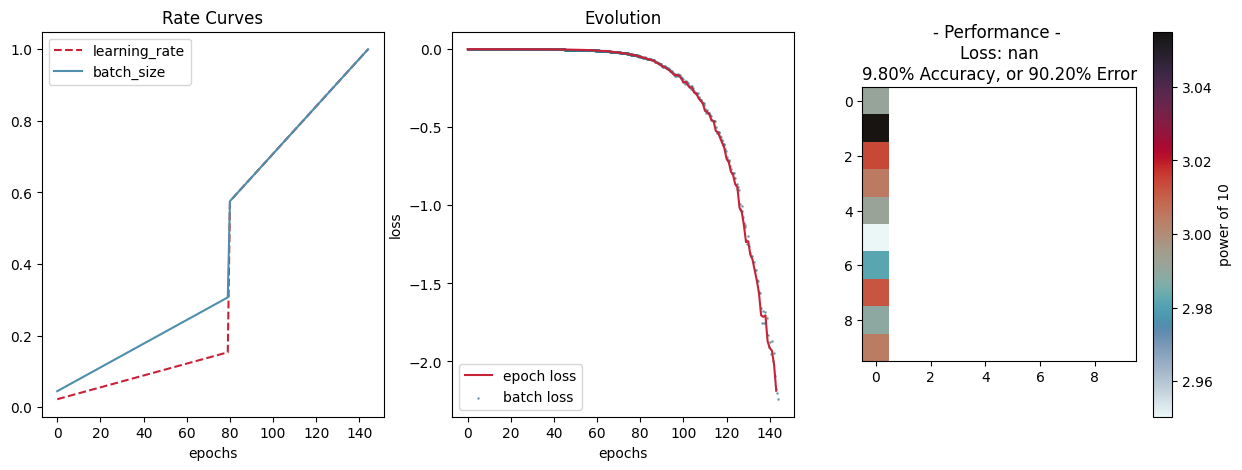

In [14]:
D.optimizer = lambda x : optim.ASGD(x, lr=0.001) 
D.max_batch_size=train_X.shape[0]
D.epochs=400
net = FFA(device, losstype=0) # expect 1.6% error rate
net.to(device)
report = D.train(net,train_X, train_y, start_batch_size=1000)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)

 30%|███       | 120/400 [00:26<01:02,  4.49it/s]


NAN


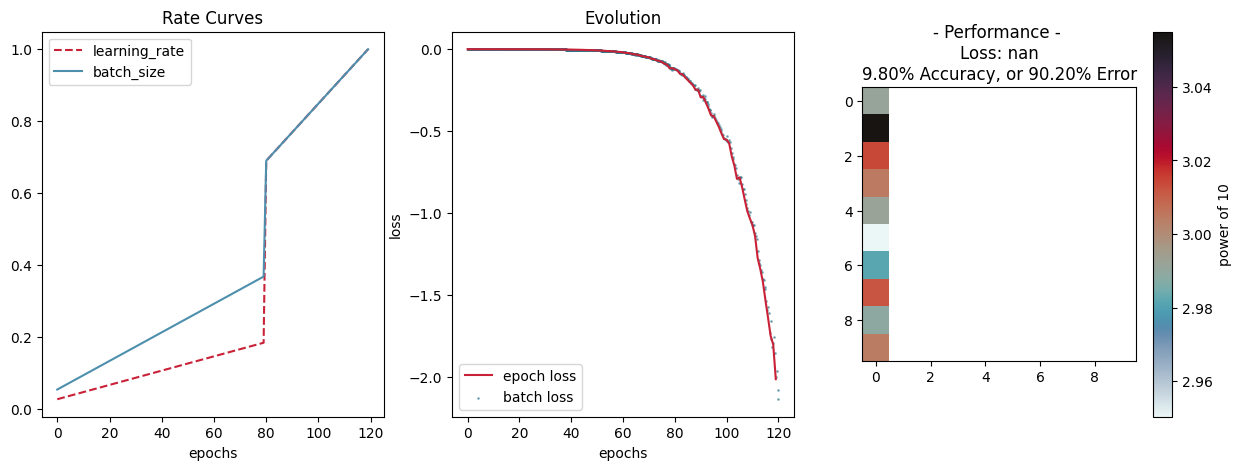

In [15]:
D.optimizer = lambda x : optim.ASGD(x, lr=0.001) 
D.max_batch_size=train_X.shape[0]
D.epochs=400
net = FFA(device, losstype=1) # expect 1.6% error rate
net.to(device)
report = D.train(net,train_X, train_y, start_batch_size=1000)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)